In [1]:
import os
import numpy as np
import cv2

In [2]:
from skimage import exposure, morphology      # for adjusting image contrast,intensity and processing of shapes
from skimage.filters import threshold_otsu
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, confusion_matrix , auc
from albumentations import Compose,Rotate, VerticalFlip , HorizontalFlip, RandomBrightnessContrast, ShiftScaleRotate        # for rotate,shift,scale ,adjust brightness of the image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Dense,Dropout,Flatten,MaxPooling2D
from tensorflow.keras.optimizers import Adam

C:\Users\Gursharan Kaur\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [3]:
from skimage.transform import resize

In [4]:
# as we are given two types of images lung masks and images so we are comibing the both types of the images for better preprocessing amd training

def combine_images_and_masks(Image_path , Mask_path):
    try:
        Images = cv2.imread(Image_path, cv2.IMREAD_GRAYSCALE)
        Masks = cv2.imread(Mask_path, cv2.IMREAD_GRAYSCALE)
        if Images is None or Masks is None:
            raise ValueError("Images or Masks are invalid")
        
        Image_resized = resize(Images, (150,150), anti_aliasing = True)
        Mask_resized = resize(Masks, (150,150), anti_aliasing = True)
        
        Combined = np.dstack((Image_resized, Mask_resized)) / 255.0 
        return Combined 
    except Exception as e:
        print("Error image and masks processing")
        return None

In [5]:
def load_and_combine_data(Base_dir , Class_name):
    Combined_data = []
    Class_dir = os.path.join(Base_dir , Class_name)
    Images_dir = os.path.join(Class_dir, 'images')
    Masks_dir = os.path.join(Class_dir, 'lung masks')
    
    if not os.path.exists(Images_dir):
        print("ERROR:- Image directory not exist")
        return np.array(Combined_data)
    
    if not os.path.exists(Masks_dir):
        print("ERROR:- Masks directory not exist")
        return np.array(Combined_data)
    
    Image_files = os.listdir(Images_dir)
    
    for Image_file in Image_files:
        Image_path = os.path.join(Images_dir, Image_file)
        Mask_path = os.path.join(Masks_dir, Image_file)
        
        if os.path.exists(Image_path) and os.path.exists(Mask_path):
            Combined = combine_images_and_masks(Image_path , Mask_path)
            if Combined is not None:
                Combined_data.append(Combined)
        else:
            if not os.path.exists(Image_path):
                print("ERROR:- Image not found")
            if not os.path.exists(Mask_path):
                print("ERROR:- Mask not found")
                
    if len(Combined_data) == 0:
        print("ERROR: Image-Masks not found")
        
    return np.array(Combined_data)

In [6]:
def apply_augmentations(data):
    Augmented_data = []
    
    for idx, img in enumerate(data):
        try:
            Rotated_img = Rotate(limit=30, p=0.5)(image=img)['image']
            Augmented_data.append(Rotated_img)
        except Exception as e:
            print("Error in Image augmenting: {e}")
            Augmented_data.append(img)  
    return np.array(Augmented_data)

In [7]:
def Image_Preprocess(image):
    try:
        thresh = threshold_otsu(image)
        binary = image > thresh
        binary_cleaned = morphology.remove_small_objects(binary, min_size=64, connectivity=2)
        equalized_image = exposure.equalize_hist(image)
        blurred_image = cv2.GaussianBlur(equalized_image, (5, 5), 0)
        
        return blurred_image
    except Exception as e:
        print("Preprocessing Image ERROR:", e)
        return None
    
def Data_Preprocess(data):
    Preprocessed_data = []
    for idx, img in enumerate(data):
        try:
            Preprocessed_img = Image_Preprocess(img[:, :, 0])
            if Preprocessed_img is not None:
                Preprocessed_data.append(Preprocessed_img)
            else:
                print(f"Preprocessing Image ERROR")
        except Exception as e:
            print(f"Preprocessing ERROR")
           
    return np.array(Preprocessed_data)


In [8]:
# showing the images 
import matplotlib.pyplot as plt 

def show_images(images, labels , num_images = 9):
    plt.figure(figsize=(10,10))
    for i in range(num_images):
        plt.subplot(3,3,i +1)
        if images[i].shape[-1]>1:
            plt.imshow(images[i,], cmap='gray')
        else:
            plt.imshow(images[i][:, :], cmap='gray')
        plt.title(labels[i])
        plt.axis('off') 
        plt.show()

In [9]:
Base_dir = r"C:\Users\Gursharan Kaur\Downloads\CovidXRayImages\Val"
Normal_Data = load_and_combine_data(Base_dir, 'Normal')
Covid_Data = load_and_combine_data(Base_dir, 'COVID-19')
Non_Covid_Data = load_and_combine_data(Base_dir, 'Non-COVID')

print(f"Number of normal images: {len(Normal_Data)}")
print(f"Number of COVID-19 images: {len(Covid_Data)}")
print(f"Number of non-COVID-19 images: {len(Non_Covid_Data)}")

Number of normal images: 1712
Number of COVID-19 images: 1903
Number of non-COVID-19 images: 1802


In [10]:
# applying the augmentations to the data
Augmented_Normal_Data = apply_augmentations(Normal_Data)
Augmented_Covid_Data = apply_augmentations(Covid_Data)
Augmented_Non_Covid_Data = apply_augmentations(Non_Covid_Data)

print(f"Number of augmented normal images: {len(Augmented_Normal_Data)}")
print(f"Number of augmented COVID-19 images: {len(Augmented_Covid_Data)}")
print(f"Number of augmented non-COVID-19 images: {len(Augmented_Non_Covid_Data)}")


Number of augmented normal images: 1712
Number of augmented COVID-19 images: 1903
Number of augmented non-COVID-19 images: 1802


In [11]:
# Preprocessing the data
Preprocessed_Normal_Data = Data_Preprocess(Augmented_Normal_Data)
Preprocessed_Covid_Data = Data_Preprocess(Augmented_Covid_Data)
Preprocessed_Non_Covid_Data = Data_Preprocess(Augmented_Non_Covid_Data)

print(f"Number of preprocessed normal images: {len(Preprocessed_Normal_Data)}")
print(f"Number of preprocessed COVID-19 images: {len(Preprocessed_Covid_Data)}")
print(f"Number of preprocessed non-COVID-19 images: {len(Preprocessed_Non_Covid_Data)}")

Number of preprocessed normal images: 1712
Number of preprocessed COVID-19 images: 1903
Number of preprocessed non-COVID-19 images: 1802


In [12]:
# Now we are combining the normal , covid-19 and NO-covid preprocessed data

X= np.concatenate((Preprocessed_Normal_Data , Preprocessed_Covid_Data , Preprocessed_Non_Covid_Data) , axis = 0 )
Y = np.array([0] * len(Preprocessed_Normal_Data) + [1] * len(Preprocessed_Covid_Data) + [2] * len(Preprocessed_Non_Covid_Data))

In [13]:
print(f"Shape of Combined data: {X.shape}")
print(f"Shape of Labels: {Y.shape}")

Shape of Combined data: (5417, 150, 150)
Shape of Labels: (5417,)


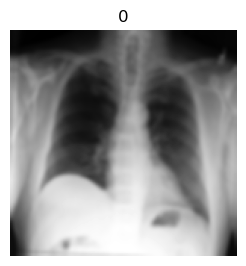

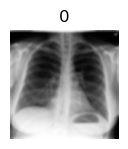

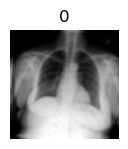

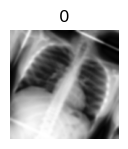

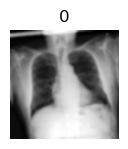

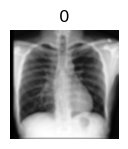

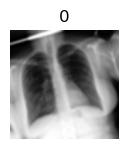

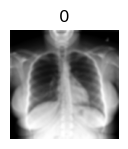

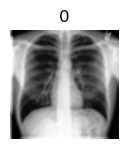

In [14]:
show_images(X,Y,num_images=9)

In [15]:
# Splitting the data  into trainging and testing 

X_train,X_test,Y_train,Y_test = train_test_split(X,Y, test_size = 0.1, random_state = 42)

In [16]:
Model = Sequential([
    Conv2D(32 , (3,3) , activation = 'relu' , input_shape = (150,150,1)),
    MaxPooling2D((2,2)),
    Conv2D(64 , (3,3) , activation = 'relu'),
    MaxPooling2D((2,2)),
    Conv2D(128 , (3,3) , activation = 'relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(128 , activation='relu'),
    Dropout(0.5),
    Dense(3 , activation = 'softmax')
])

C:\Users\Gursharan Kaur\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
# Now we are going to compile the model 

Model.compile(optimizer = 'adam',
             loss = 'sparse_categorical_crossentropy',
             metrics = ['accuracy'])

In [18]:
# Now we are proceding to train the Model

from tensorflow.keras.callbacks import EarlyStopping

History = Model.fit(X_train , Y_train , epochs = 10, batch_size =32 , validation_split = 0.2, callbacks=[EarlyStopping(patience = 3)])

Epoch 1/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 60s 436ms/step - accuracy: 0.4352 - loss: 1.0469 - val_accuracy: 0.5672 - val_loss: 0.8819
Epoch 2/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 53s 431ms/step - accuracy: 0.5648 - loss: 0.8973 - val_accuracy: 0.6533 - val_loss: 0.7608
Epoch 3/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 53s 432ms/step - accuracy: 0.6479 - loss: 0.8068 - val_accuracy: 0.6923 - val_loss: 0.7083
Epoch 4/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 53s 430ms/step - accuracy: 0.6943 - loss: 0.7068 - val_accuracy: 0.7087 - val_loss: 0.6804
Epoch 5/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 52s 429ms/step - accuracy: 0.7207 - loss: 0.6603 - val_accuracy: 0.7179 - val_loss: 0.6707
Epoch 6/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 52s 430ms/step - accuracy: 0.7438 - loss: 0.5984 - val_accuracy: 0.7426 - val_loss: 0.6063
Epoch 7/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 53s 431ms/step - accuracy: 0.7708 - loss: 0.5457 - val_accuracy: 0.7600 - val_loss: 0.5732
Epoch 8/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 52s 429ms/step - accuracy: 0.8153 - loss: 0

In [19]:
# Model accuracy check 
test_loss , test_accu = Model.evaluate(X_test , Y_test)
print("Test Accuracy of Model is:-" , test_accu)

17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 0.7395 - loss: 0.7061
Test Accuracy of Model is:- 0.7564575672149658


<function matplotlib.pyplot.show(close=None, block=None)>

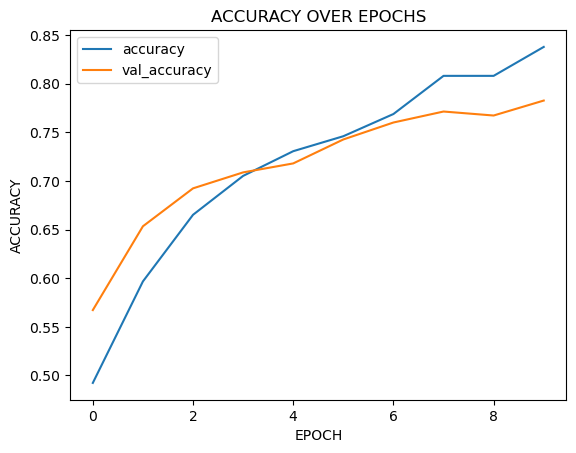

In [20]:
import matplotlib.pyplot as plt 

plt.plot(History.history['accuracy'] , label = 'accuracy')

plt.plot(History.history['val_accuracy'] , label = 'val_accuracy')

plt.xlabel("EPOCH")
plt.ylabel("ACCURACY")
plt.title("ACCURACY OVER EPOCHS")
plt.legend()
plt.show

17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step
Confusion Matrix is := 
[[117  33  22]
 [  9 145  14]
 [ 29  25 148]]
CONFUSION MATRIX PLOTTED:
              precision    recall  f1-score   support

      Normal       0.75      0.68      0.72       172
    Covid-19       0.71      0.86      0.78       168
   Non-Covid       0.80      0.73      0.77       202

    accuracy                           0.76       542
   macro avg       0.76      0.76      0.75       542
weighted avg       0.76      0.76      0.76       542



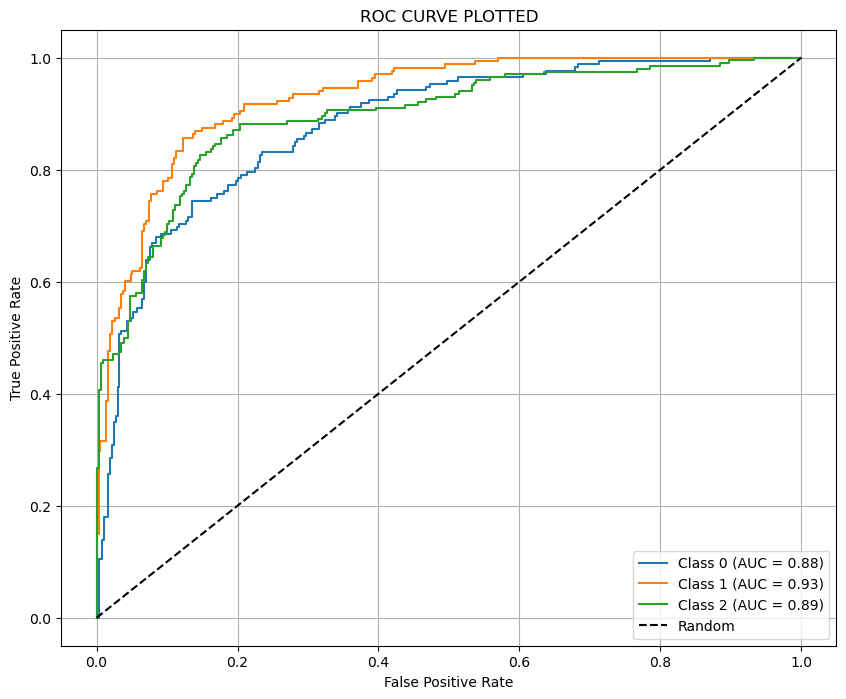

In [21]:
from sklearn.metrics import classification_report
# Getting the probability of the test data

Y_prob = Model.predict(X_test)
Y_labels = np.argmax(Y_prob , axis = 1)

# Building a Confusion Matrix 
Conf_Matrix = confusion_matrix(Y_test , Y_labels)
print("Confusion Matrix is := ")
print(Conf_Matrix)


# Classification Report 
print("CONFUSION MATRIX PLOTTED:")
print(classification_report(Y_test , Y_labels , target_names = ['Normal','Covid-19' , 'Non-Covid']))

# Plotting the ROC CURVE and AUC
false_positive_rate = dict()
true_positive_rate= dict()
Area_Under_Curve = dict()

for i in range(3):   # 3 because we have three classes Normal, Covid19 and NON-Covid
    false_positive_rate[i],true_positive_rate[i], _ = roc_curve(Y_test == i , Y_prob[: , i])
    Area_Under_Curve[i] = auc(false_positive_rate[i] , true_positive_rate[i])
    
plt.figure(figsize = (10,8))
for i in range(3):
    plt.plot(false_positive_rate[i] , true_positive_rate[i] , label =f'Class {i} (AUC = {Area_Under_Curve[i]:.2f})')
    
plt.plot([0,1] , [0,1] , 'k--',label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE PLOTTED')
plt.legend()
plt.grid(True)
plt.show()

In [22]:
import os
import tensorflow as tf
from tensorflow.keras.models import load_model

In [23]:
# starting to tune the CNN MODEL  

import tensorflow as tf
import keras_tuner as kt

def model_build(hp):
    Model = tf.keras.Sequential()
    Model.add(tf.keras.layers.Conv2D(
         filters = hp.Int('conv_1_filter' , min_value = 32 , max_value = 64, step = 12),
         kernel_size = hp.Choice('conv_1_kernel' , values = [3,5]),
         activation = 'relu',
         input_shape = (150,150,1)
    ))
    
    Model.add(MaxPooling2D((2, 2)))
    Model.add(Conv2D(
        filters=hp.Int('conv_2_filter', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('conv_2_kernel', values=[3, 5]),
        activation='relu'
    ))
    Model.add(MaxPooling2D((2, 2)))
    Model.add(Conv2D(
        filters=hp.Int('conv_3_filter', min_value=64, max_value=128, step=32),
        kernel_size=hp.Choice('conv_3_kernel', values=[3, 5]),
        activation='relu'
    ))
    Model.add(MaxPooling2D((2, 2)))
    Model.add(Flatten())
    Model.add(Dense(
        units=hp.Int('dense_units', min_value=64, max_value=256, step=32),
        activation='relu'
    ))
    Model.add(Dropout(0.5))
    Model.add(Dense(3, activation='softmax'))

    Model.compile(optimizer=hp.Choice('optimizer', values=['adam', 'rmsprop']),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return Model

In [24]:
Tuner = kt.RandomSearch(
         model_build,
         objective = 'val_accuracy',
         max_trials = 5,
         executions_per_trial = 1,
         directory = 'my_dir',
         project_name = 'model_tuning')

Tuner.search(X_train , Y_train , epochs = 10 , validation_split = 0.1)

Trial 5 Complete [00h 30m 52s]
val_accuracy: 0.7540983557701111

Best val_accuracy So Far: 0.7725409865379333
Total elapsed time: 01h 09m 40s


In [25]:
Best_Model = Tuner.get_best_models(num_models =1)[0]
Best_Model.summary()

C:\Users\Gursharan Kaur\anaconda3\lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 44)   │           440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 44)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 80)     │        31,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 80)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 64)     │        46,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18496)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 160)            │     2,959,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 160)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           483 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,038,347 (11.59 MB)

 Trainable params: 3,038,347 (11.59 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
# Assuming 'model' is your trained CNN model
Model.save("my_cnn_model.keras", include_optimizer=True)
